# Dictionary

The business needs to have a dictionary for Manufacturer, for all different spellmissings, this using a previous dictionary created, mapping some spellmissings with the correct Manufacturer name.

# Libraries

In [1]:
library(dplyr)
library(ggplot2)
library(forcats)
library(readr)
library(readxl)
library(stringdist)
library(purrr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Read Data

Dictionary

In [2]:
dic <- readxl::read_excel('/Users/darias/Documents/Dictionaries/US/Data/Distribución Abril FY19.xlsx')

Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in E10770 / R10770C5: got 'LEICA'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in E60496 / R60496C5: got 'LUICA'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting logical in E60497 / R60497C5: got 'LEICA'”
New names:
* `` -> ...4
* `` -> ...5



In [3]:
nrow(dic)

[1] 72075

Manufacturer data from last 6 years for US

In [4]:
data <- read_csv('/Users/darias/Documents/Dictionaries/US/Data/Manufacturer_Data_US.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  customerID = col_double(),
  primaryLoan = col_double(),
  itemID = col_double(),
  itemEZPrice = col_double(),
  itemLoanAmt = col_double(),
  itemLTV = col_double(),
  itemLowAmt = col_double(),
  itemHighAmt = col_double(),
  itemRanking = col_double(),
  teamMember = col_double(),
  numberItemsInLoan = col_double(),
  dropFlag = col_double(),
  redeemFlag = col_double(),
  activeLoanFlag = col_double(),
  loanExtensions = col_double(),
  loanExtensionDollars = col_double(),
  loanRenewals = col_double(),
  loanRenewalsDollars = col_double(),
  loanPSC = col_double(),
  pos1_PUR = col_double()
  # ... with 13 more columns
)

See spec(...) for full column specifications.

Warning message:
“3968 parsing failures.
 row      col expected actual                                                                    file
2783 pos1_PUR a double   NULL '/Users/darias/Documents/Dictionaries/US/Data/Manufacturer_Data_US.csv'


# Manufacturer Fixed

Put the manufacterer fixed for electronics:

 1. If the Manufacturer matches with the Manufacturer in the dictionary, then will stay as the same
 2. If Manufacturer doesn't match with the dictionary, then see if matches with a spellmissing and use th correct manufacturer
 3. If not matches with Manufacturer or SpellMissing Manufacturer, then use the closest approach using a similarity metric
 4. If the similarity metric is non reepresentativa, assign a "Non Manufacturer"

In [5]:
dic %>%
 mutate(Manufacturer = tolower(Manufacturer),
        Alias        = tolower(Alias)) %>%
 distinct(Manufacturer,Alias) %>%
 rename('Manufacturer_spellmiss' = 'Alias',
        'Manufacturer_EZ' = 'Manufacturer') -> dic_clean

Manufacturer_correct  <- unique(tolower(dic$Alias))
Manufacturer_spellmiss <- unique(tolower(dic$Manufacturer))

In [6]:
#data %>%
# filter(Secondary == 'Electronics') %>% nrow

In [7]:
data %>%
# filter(Secondary == 'Electronics') %>%
 mutate(Manufacturer_EZ = tolower(Manufacturer_EZ)) %>%
 mutate(Manufacturer_Alias = ifelse(Manufacturer_EZ %in% Manufacturer_correct, Manufacturer_EZ, NA)) %>%
 left_join(.,dic_clean, by = 'Manufacturer_EZ') -> data_clean

## Spellmissing function

Calculate the Jaccard distance for all the Spellmissings and Alias for those cases where didn't have a match in Alias or Spellmissing.

In [8]:
alias_fun <- function(x){
    
    options(warn=-1)
    
    word   <- tolower(x)
    alias  <- tolower(unique(dic$Alias))
    spellm <- tolower(unique(dic$Manufacturer))
    
    # Alias Similarity
    data.frame(word  = word,
               alias = alias) -> df_alias
    
    df_alias$similarity <- stringdist(df_alias$word, df_alias$alias, method='jaccard', q=2)
    
    df_alias %>%
     arrange(similarity) %>%
     head(1) %>%
     select(alias) %>%
     pull -> alias_similar
    
    df_alias %>%
     arrange(similarity) %>%
     head(1) %>%
     select(similarity) %>%
     pull -> alias_jaccard
    
    df_aux_alias <- data.frame(word                 = as.character(word),
                               index_jaccard        = (alias_jaccard),
                               Manufacturer_jaccard = as.character(alias_similar)) %>% distinct(word,index_jaccard,Manufacturer_jaccard)
    
    # SpellMissing Similarity
    data.frame(word   = word,
               spellm = spellm) -> df_spellm
    
    
    df_spellm$similarity <- stringdist(df_spellm$word, df_spellm$spellm, method='jaccard', q=2)
    
    df_spellm %>%
     arrange(similarity) %>%
     head(1) %>%
     select(spellm) %>%
     pull -> spellm_min
    
    df_spellm %>%
     arrange(similarity) %>%
     head(1) %>%
     select(similarity) %>%
     pull -> spellm_jaccard
    
    dic %>%
     filter(tolower(Manufacturer) == spellm_min) %>%
     select(Alias) %>%
     pull -> spellm_similar
    
    df_aux_spellm <- data.frame(word                 = as.character(word),
                                index_jaccard        = (spellm_jaccard),
                                Manufacturer_jaccard = as.character(spellm_similar)) %>% distinct(word,index_jaccard,Manufacturer_jaccard)
    
    if(spellm_similar==alias_jaccard){
        sim <- df_aux_alias
    } else if(alias_jaccard > spellm_similar){
        sim <- df_aux_alias} else {sim <- df_aux_spellm}
    

    sim %>%
     mutate(Manufacturer_jaccard = as.character(Manufacturer_jaccard),
            word                 = as.character(word),
            Manufacturer_jaccard = ifelse(index_jaccard >= 0.6, 'No_Manufacturer', Manufacturer_jaccard)) -> sim
    
    return(sim)
    
}




Examples

In [50]:
stringdist('maicrosot', 'maicosoft', method='jaccard', q=2)

[1] 0.5454545

In [49]:
stringdist('microsoft', 'maicrsoft', method='jaccard', q=2)

[1] 0.5454545

In [52]:
alias_fun('aaple')
alias_fun('samsngggg')
alias_fun('1234')
alias_fun('')
alias_fun('aobjbcbo')
alias_fun('0neida')
alias_fun('micsot')



word  index_jaccard Manufacturer_jaccard
1 aaple 0             APPLE

word      index_jaccard Manufacturer_jaccard
1 samsngggg 0.1666667     SAMSUNG

word index_jaccard Manufacturer_jaccard
1 1234 0.6           No_Manufacturer

word index_jaccard Manufacturer_jaccard
1      1             No_Manufacturer

word     index_jaccard Manufacturer_jaccard
1 aobjbcbo 0.625         No_Manufacturer

word   index_jaccard Manufacturer_jaccard
1 0neida 0             ONEIDA

word   index_jaccard Manufacturer_jaccard
1 micsot 0.4285714     MICROSOFT

## Cases with and without match

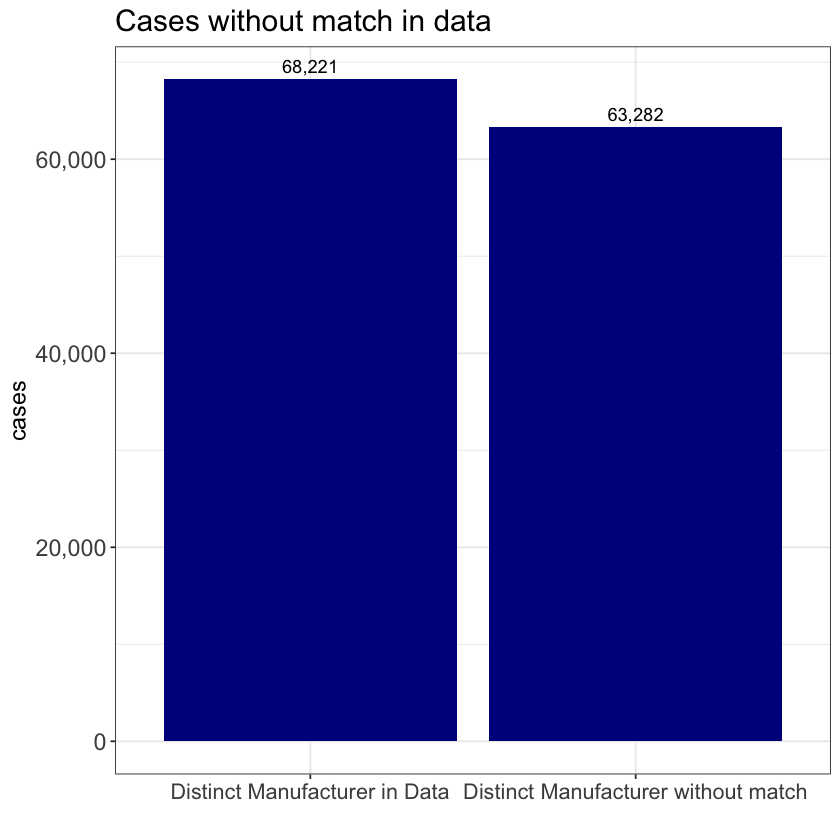

In [10]:
a <- unique(data_clean$Manufacturer_EZ) %>% length

b <- data_clean %>%
 filter(is.na(Manufacturer_Alias) | is.na(Manufacturer_spellmiss)) %>%
 select(Manufacturer_EZ) %>%
 distinct(Manufacturer_EZ) %>%
 nrow

data.frame(desc  = c('Distinct Manufacturer in Data', 'Distinct Manufacturer without match'),
           cases = c(a,b)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = cases), fill = 'darkblue') +
 theme_bw() +
 ggtitle('Cases without match in data') +
 scale_y_continuous(labels = scales::comma) +
 geom_text(aes(x = desc, y = cases, label = scales::comma(cases)), vjust = -0.5) +
 theme(axis.text.x  = element_text(size = 13),
       axis.text.y  = element_text(size = 14),
       axis.title.y = element_text(size = 14),
       title        = element_text(size = 15)) +
 xlab('')

## Correct data

Create a new column in the data with the manufacturer fixed

In [15]:
# data frame with the distinct cases of Manufacturer_EZ (Manufacturer in EZSystem)
df_ez <- data.frame(Manufacturer_EZ    = data %>%
                                          select(Manufacturer_EZ) %>%
                                          mutate(Manufacturer_EZ = as.character(Manufacturer_EZ)) %>%
                                          filter(!is.na(Manufacturer_EZ)) %>%
                                          distinct(Manufacturer_EZ) %>%
                                          pull,
                    Manufacturer_fixed = NA) %>%
         mutate(Manufacturer_EZ = as.character(Manufacturer_EZ),
                Manufacturer_fixed = as.character(Manufacturer_fixed))

nrow(df_ez)

ptm <- proc.time()
# add the manufacturer fixed with a for loop
for(i in 1:nrow(df_ez)){
    w                           <- df_ez$Manufacturer_EZ[i]
    word_fixed                  <- alias_fun(w)$Manufacturer_jaccard[1]
    df_ez$Manufacturer_fixed[i] <- word_fixed
}
proc.time() - ptm

[1] 87678

      user     system    elapsed 
252207.032   1718.668  24019.598 

Write Dictionary

In [16]:
setwd('/Users/darias/Documents/Dictionaries/US/Data_Out/')
write.csv(df_ez,file = 'Dictionary_EzSystem_Manufacturer.csv', row.names = FALSE)

In [55]:
df_ez %>%
 filter(Manufacturer_fixed == 'No_Manufacturer') %>%
 head

Manufacturer_EZ Manufacturer_fixed
1 DOONEYBOURKE    No_Manufacturer   
2 JOE BALABUSHKA  No_Manufacturer   
3 NOMFT           No_Manufacturer   
4 JNY-LX2         No_Manufacturer   
5 BBT             No_Manufacturer   
6 DOONEY & BOURKE No_Manufacturer

In [31]:
17663/nrow(df_ez)

[1] 0.201453

In [54]:
nrow(df_ez) - 17663

[1] 70015

In [57]:
head(df_ez)

Manufacturer_EZ  Manufacturer_fixed
1 CRAFTSMAN        CRAFTSMAN         
2 OZARK TRAIL      OZARK TRAIL       
3 DOGZ             DOGG DIGITAL AUDIO
4 CHICAGO ELECTRIC CHICAGO ELECTRIC  
5 RIDGID           RIDGID            
6 DEWALT           DEWALT

Add the Manufacturer fixed to the table with a left join

In [23]:
data %>%
 left_join(df_ez, by = 'Manufacturer_EZ') -> data

In [27]:
data %>%
 mutate(Manufacturer_fixed = ifelse(is.na(Manufacturer_EZ), 'No_Manufacturer',Manufacturer_fixed )) -> data

# Fix Manufacturer Function examples

In [62]:
alias_fun('hp')

word index_jaccard Manufacturer_jaccard    
1 hp   0             HEWLETT PACKARD         
2 hp   0             HEWLETT PACKARD / COMPAQ
3 hp   0             HEWLETT PACKARD/COMPAQ

In [58]:
alias_fun('aaple')
alias_fun('samsngggg')
alias_fun('1234')
alias_fun('')
alias_fun('aobjbcbo')
alias_fun('0neida')
alias_fun('micsot')

word  index_jaccard Manufacturer_jaccard
1 aaple 0             APPLE

word      index_jaccard Manufacturer_jaccard
1 samsngggg 0.1666667     SAMSUNG

word index_jaccard Manufacturer_jaccard
1 1234 0.6           No_Manufacturer

word index_jaccard Manufacturer_jaccard
1      1             No_Manufacturer

word     index_jaccard Manufacturer_jaccard
1 aobjbcbo 0.625         No_Manufacturer

word   index_jaccard Manufacturer_jaccard
1 0neida 0             ONEIDA

word   index_jaccard Manufacturer_jaccard
1 micsot 0.4285714     MICROSOFT